In [1]:
!pip install backtesting
import scipy
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pandas_ta as ta
import yfinance as yahooFinance
import datetime
!pip install pandas_ta
import pandas_ta as ta

In [2]:
GetFacebookInformation = yahooFinance.Ticker("META")
startDate = datetime.datetime(2012, 5, 31)

# endDate , as per our convenience we can modify
endDate = datetime.datetime(2024, 4, 30)
data = GetFacebookInformation.history(start=startDate,
                                     end=endDate)

In [46]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(100).shift(-100)  # Returns after roughly two days
    y[y.between(-.005, .005)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

In [47]:
from scipy.stats import linregress

def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
upper, lower = BBANDS(data, 20, 2)


# Price-derived features
data['MA20'] = data.ta.sma(length=20)
data['MA50'] = data.ta.sma(length=50)
data['MA200'] = data.ta.sma(length=200)
data['X_RSI'] = data.ta.rsi()
data['X_EMA']=ta.sma(data.Close, length=200)#sma ema

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close

In [48]:
data = data.dropna().astype(float)


In [49]:
X, y = get_clean_Xy(data)

Classification accuracy:  0.8173913043478261


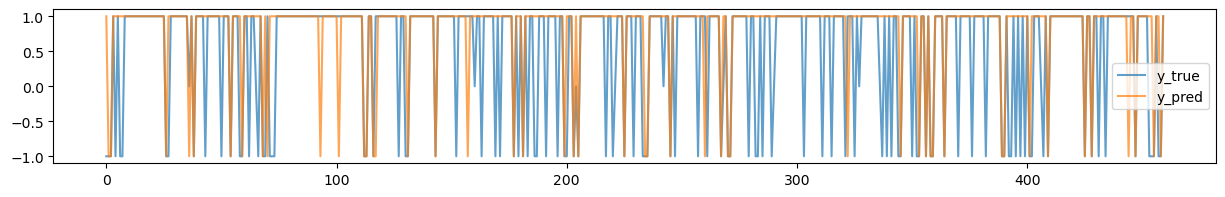

In [50]:
from sklearn.model_selection import train_test_split
from sklearn import svm
X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
clfsvm = svm.SVC()
clfsvm.fit(X_train, y_train)
y_pred = clfsvm.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))


In [51]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 1000


class MLTrainOnceStrategy(Strategy):
    price_delta = .008  # 0.4%

    def init(self):
        # Init our model, a kNN classifier
        self.clf = svm.SVC(kernel='rbf', C=.1)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and self.data['X_RSI'] < 50 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        else:
             for trade in self.trades:
                if current_time - trade.entry_time > pd.Timedelta('3 days'):
                    if trade.is_long:
                        trade.close()
     
        # Additionally, set aggressive stop-loss on trades that have been open
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('3 days'):
                if trade.is_long:
                    trade.close()
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, cash=10000, commission=.0002, margin=.05)
bt.run()

CPU times: user 349 ms, sys: 2.5 ms, total: 351 ms
Wall time: 356 ms


Start                     2014-10-15 00:00...
End                       2024-04-29 00:00...
Duration                   3484 days 00:00:00
Exposure Time [%]                   20.333333
Equity Final [$]                    58.472945
Equity Peak [$]                       10000.0
Return [%]                         -99.415271
Buy & Hold Return [%]              491.557158
Return (Ann.) [%]                   -41.71856
Volatility (Ann.) [%]               12.103631
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -99.4281
Avg. Drawdown [%]                    -99.4281
Max. Drawdown Duration     2035 days 00:00:00
Avg. Drawdown Duration     2035 days 00:00:00
# Trades                                  486
Win Rate [%]                        19.341564
Best Trade [%]                       1.376281
Worst Trade [%]                      -3.93197
Avg. Trade [%]                    

In [53]:
 bt.plot()

/Users/meshu/Desktop/tensorflow-test/env/lib/python3.8/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/meshu/Desktop/tensorflow-test/env/lib/python3.8/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p5742', ...)